In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

In [3]:
#kulutus ennuste
url_166 = "https://api.fingrid.fi/v1/variable/166/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"
#tuulivoima tuotanto ennuste
url_245 = "https://api.fingrid.fi/v1/variable/245/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"
#sähkötuotanto ennuste
url_241 = "https://api.fingrid.fi/v1/variable/241/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"

def GetDataAPI(url):
    df_kulutus = pd.read_csv(url)

    df_kulutus.columns = ["start_time","end_time","value"]

    # Convert value to pd datetime
    df_kulutus["start_time"] = pd.to_datetime(df_kulutus["start_time"])
    print(df_kulutus["start_time"].dtypes)
    
    # Start time of interval
    start_date = pd.to_datetime("today")
    print(start_date)

    # Rajataan aikavälin mukaan
    df_kulutus_filt = df_kulutus[(df_kulutus["start_time"] > start_date)]

    # Valitaan vain kolme saraketta
    df_kulutus_filt = df_kulutus_filt[['start_time' 'value']]
    data = df_kulutus_filt.values.tolist()
    
    data.to_csv("../Data/kulutus_ennuste.csv")

GetDataAPI(url_166) # kulutusennuste

datetime64[ns, UTC]
2022-11-05 15:27:31.284245


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [3]:
df_kulutus = pd.read_csv("../Data/Kulutusennuste_Tammikuu_2021.csv")
df_tuotanto = pd.read_csv("../Data/Sahkontuotantoennuste_Tammikuu_2021.csv")

In [77]:
"""
Params:
interval = int
    how many data points to take account to find best rolling average

duration = int
    how many data points take count to calculating average

arr = [[start, end, value], [start, end, value],...]
    list of lists containing starting time ending time and value
"""
def ChargingTime(interval, duration, arr):
    # Käydään läpi ennustearvot ja lasketaan 'duration' pituinen liukuva keskiarvo
    # Keskiarvot taulukkoon jossa sarakkeet 'aloitusaika', 'lopetusaika' ja 'keskiarvo'
    # Keskiarvoista valitaan pienin
    # Return pienimmän keskiarvon aloitusaika
    
    avgs = []
    duration = round(duration / 5)
    interval = round(interval / 5)
        # Calculates averages
    for i in range(len(arr) - duration + 1):
        t1 = arr[i][0]
        t2 = arr[i][1]

        # Check if duration difference is bigger than interval
        if (pd.Timedelta(t2-t1).seconds / 60.0) > interval:
            break
        else:
            window = arr[i : i + duration]
            sum = 0
            for j in window:
                sum = sum + j[2]

            window_avg = round(sum / duration, 3)
                
            if (len(arr) - 1) > i + duration:
                avgs.append([arr[i][0], arr[i + duration][1], window_avg])

    # Find min average and select the starting duration to achieve that
    min_avg = [float('inf'), "", ""]
    for k in avgs:
        
        if min_avg[0] > k[2]:
            min_avg[0] = k[2]
            min_avg[1] = k[0]
            min_avg[2] = k[1]

    return min_avg

In [80]:
# Muutetaan arvot datetime:ksi
df_kulutus["Alkuaika UTC+02:00"] = pd.to_datetime(df_kulutus["Alkuaika UTC+02:00"])
df_kulutus["Lopetusaika UTC+02:00"] = pd.to_datetime(df_kulutus["Lopetusaika UTC+02:00"])

# Nimetään aikaväli
start_date = pd.to_datetime("2021-01-20 01:00:00")
end_date = pd.to_datetime("2021-01-21 23:00:00")

# Rajataan aikavälin mukaan
df_kulutus_filt = df_kulutus[(df_kulutus['Alkuaika UTC+02:00'] > start_date) & (df_kulutus['Lopetusaika UTC+02:00'] <= end_date)]

# Valitaan vain kolme saraketta
df_kulutus_filt = df_kulutus_filt[['Alkuaika UTC+02:00', 'Lopetusaika UTC+02:00', 'Kulutusennuste - seuraava vuorokausi']]
data = df_kulutus_filt.values.tolist()

In [82]:
def FindChargingTime(df, kesto, intervalli):
    
    output = ChargingTime(intervalli, kesto, df)
    
    plt.rcParams["figure.figsize"] = [8, 4]
    plt.rcParams["figure.autolayout"] = True

    plt.plot(df_kulutus_filt["Alkuaika UTC+02:00"], df_kulutus_filt["Kulutusennuste - seuraava vuorokausi"])
    plt.scatter(output[1], output[0], c="red")
    plt.scatter(output[2], output[0], c="red")

    x_values = [output[1], output[2]]
    y_values = [output[0], output[0]]

    plt.plot(x_values, y_values, c="red", linestyle="--", label="Charging time")
    plt.legend()
    plt.show()

    return str(output[1])

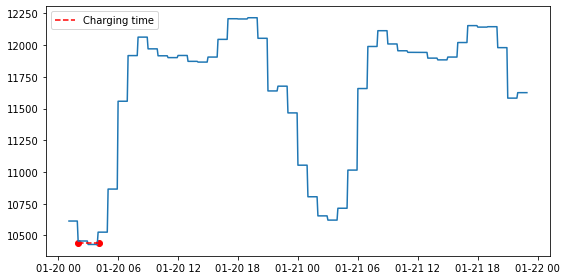

'2021-01-20 02:00:00'

In [83]:
FindChargingTime(data, 120, 5000)